# NON PARAMETRIC (WN) SPEED OF MEAN REVERSION MODEL

Import necessary librarires

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import pywt
import torch 
import scipy
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, kpss
from hurst import compute_Hc, random_walk

# DATA IMPORT

In [2]:
temp_data = pd.read_csv('../../Data/train_data_HDD.csv')
# Convert the 'date' column to datetime
temp_data['date'] = pd.to_datetime(temp_data['date'])
temp_data['average_temperature'] = (temp_data['min']+temp_data['max'])/2

temp_data = temp_data[temp_data['date'] >= '1970-01-01']

We skip the data analysis that is done in Main.ipynb

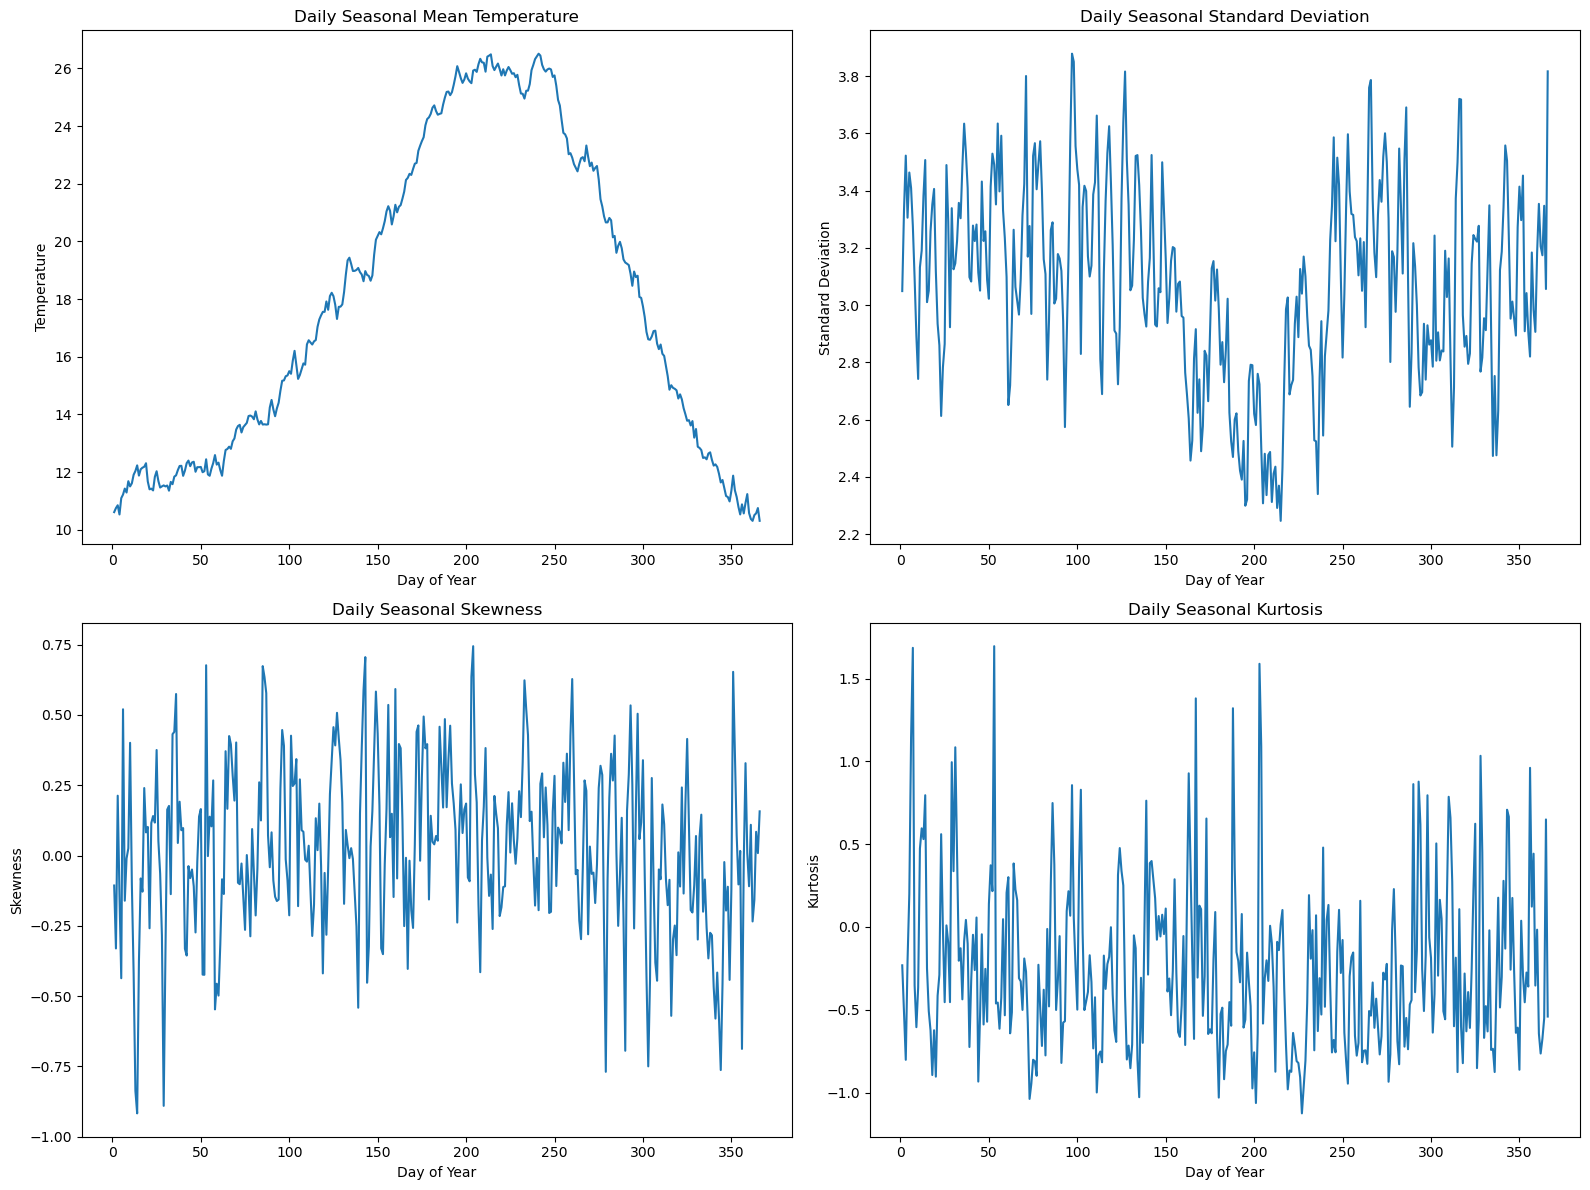

In [3]:
daily_seasonal_mean = temp_data.groupby(temp_data['date'].dt.dayofyear)['average_temperature'].mean()
daily_seasonal_std = temp_data.groupby(temp_data['date'].dt.dayofyear)['average_temperature'].std()
daily_seasonal_skew = temp_data.groupby(temp_data['date'].dt.dayofyear)['average_temperature'].skew()
daily_seasonal_kurtosis = temp_data.groupby(temp_data['date'].dt.dayofyear)['average_temperature'].apply(scipy.stats.kurtosis)

plt.figure(figsize=(16, 12))

plt.subplot(2, 2, 1)
daily_seasonal_mean.plot(title='Daily Seasonal Mean Temperature')
plt.xlabel('Day of Year')
plt.ylabel('Temperature')

plt.subplot(2, 2, 2)
daily_seasonal_std.plot(title='Daily Seasonal Standard Deviation')
plt.xlabel('Day of Year')
plt.ylabel('Standard Deviation')

plt.subplot(2, 2, 3)
daily_seasonal_skew.plot(title='Daily Seasonal Skewness')
plt.xlabel('Day of Year')
plt.ylabel('Skewness')

plt.subplot(2, 2, 4)
daily_seasonal_kurtosis.plot(title='Daily Seasonal Kurtosis')
plt.xlabel('Day of Year')
plt.ylabel('Kurtosis')

plt.tight_layout()
plt.show()

# MEAN MODELLING
- Perform ADF and KPSS tests on the raw temperature data.
- Deseasonalize the temperature data by subtracting the daily seasonal mean.
- Perform ADF and KPSS tests on the deseasonalized temperature data.
- Detrend the time series using an OLS regression.
- Deseasonalize and whiten the detrended series.
- Perform ADF and KPSS tests on the deseasonalized and detrended series.
- Estimate the Hurst exponent of the original and processed series.
- Plot the ACF and PACF of the processed series.
      

ADF and KPSS tests for stationarity

In [4]:
# Function to perform the ADF test
def adf_test(series, title=''):
    print(f'ADF Test for {title}')
    result = adfuller(series.dropna())
    
    print('ADF Statistic: {:.4f}'.format(result[0]))
    print('p-value: {:.4f}'.format(result[1]))
    
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {:.4f}'.format(key, value))
    
    if result[1] <= 0.05:
        print("=> Reject the null hypothesis (H0). The data is stationary.")
    else:
        print("=> Failed to reject the null hypothesis (H0). The data is non-stationary.")
    print("\n")

# Function to perform the KPSS test
def kpss_test(series, title=''):
    print(f'KPSS Test for {title}')
    result = kpss(series.dropna())
    
    print('KPSS Statistic: {:.4f}'.format(result[0]))
    print('p-value: {:.4f}'.format(result[1]))
    
    print('Critical Values:')
    for key, value in result[3].items():
        print('\t{}: {:.4f}'.format(key, value))
    
    if result[1] <= 0.05:
        print("=> Reject the null hypothesis (H0). The data is non-stationary.")
    else:
        print("=> Failed to reject the null hypothesis (H0). The data is stationary.")
    print("\n")

# Perform tests on raw temperature data
adf_test(temp_data['average_temperature'], "Raw Temperature Data")
kpss_test(temp_data['average_temperature'], "Raw Temperature Data")



ADF Test for Raw Temperature Data
ADF Statistic: -10.7353
p-value: 0.0000
Critical Values:
	1%: -3.4307
	5%: -2.8617
	10%: -2.5668
=> Reject the null hypothesis (H0). The data is stationary.


KPSS Test for Raw Temperature Data
KPSS Statistic: 0.0891
p-value: 0.1000
Critical Values:
	10%: 0.3470
	5%: 0.4630
	2.5%: 0.5740
	1%: 0.7390
=> Failed to reject the null hypothesis (H0). The data is stationary.




/var/folders/8x/z8_ybmwx7tq_c10hj9qc7rx40000gn/T/ipykernel_1915/3052179037.py:22: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna())


## Linear Trend

first we need to prep the data further, removing feb 29 and adding an index 

In [5]:
df = temp_data.copy()

# Remove February 29 to have a consistent 365-day calendar
# Remove February 29
df = df[~((df['date'].dt.month == 2) & (df['date'].dt.day == 29))]

# Create a 'month_day' string column (e.g., '01-01', '12-31')
df['month_day'] = df['date'].dt.strftime('%m-%d')

# Reset index and add t = 1, 2, ..., N
df = df.reset_index(drop=True)
df['t'] = df.index + 1


we estimate and remove the trend: 
We estimate and remove the trend using a linear regression model defined as:

$$\text{Trend}(t) = a + b \cdot t$$

where:
- $a$ is the intercept parameter
- $b$ is the slope parameter (rate of change over time)
- $t$ is the time index (1, 2, ..., n)

This linear trend is estimated using ordinary least squares (OLS) regression and then subtracted from the original temperature series to obtain the detrended data.


Slope: 0.00003
Intercept: 17.56861
t-statistic: 4.32258
p-value: 0.00002


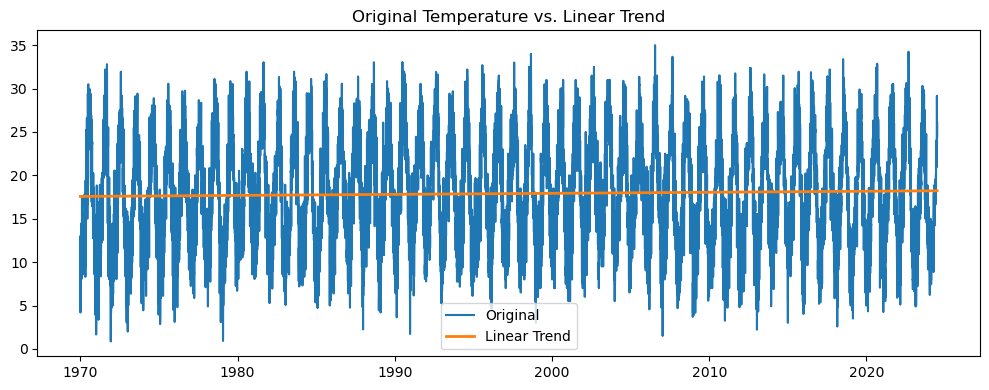

In [6]:
from scipy.stats import linregress

# Extract t and temperature
t = df['t'].values
temp = df['average_temperature'].values

# Fit linear trend and obtain detailed statistics
result = linregress(t, temp)
slope, intercept, r_value, p_value, std_err = result
trend = intercept + slope * t

# Compute t-statistic manually (optional, since p-value is already given by linregress)
t_statistic = slope / std_err

# Print results
print(f"Slope: {slope:.5f}")
print(f"Intercept: {intercept:.5f}")
print(f"t-statistic: {t_statistic:.5f}")
print(f"p-value: {p_value:.5f}")

# Add trend and detrended series to DataFrame
df['trend'] = intercept + slope * df['t']
df['detrended_temp'] = df['average_temperature'] - df['trend']

# Plot to visualize trend
plt.figure(figsize=(10, 4))
plt.plot(df['date'], df['average_temperature'], label='Original')
plt.plot(df['date'], df['trend'], label='Linear Trend', linewidth=2)
plt.title('Original Temperature vs. Linear Trend')
plt.legend()
plt.tight_layout()
plt.show()

trend_values = [slope, intercept, r_value, p_value, std_err]

In [7]:
import json

linear_trend_values_dict = {
    "slope": slope,
    "intercept": intercept,
    "r_value": r_value,
    "p_value": p_value,
    "std_err": std_err
}

with open("linear_trend_params.json", "w") as f:
    json.dump(linear_trend_values_dict, f)

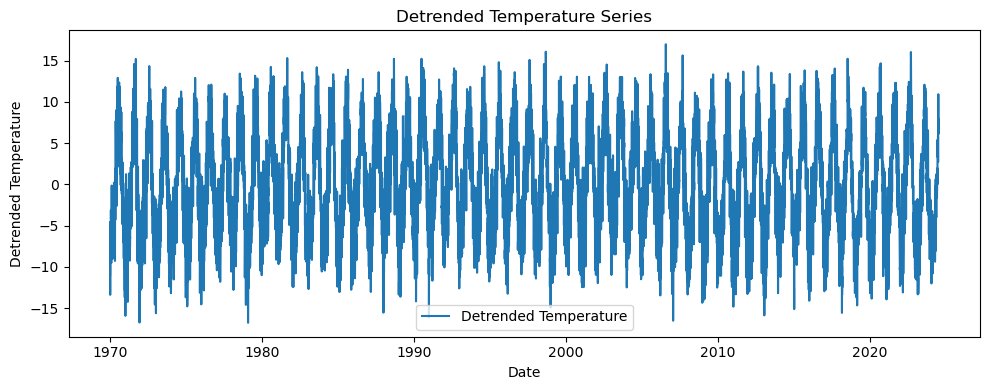

In [8]:
# Plot detrended series
plt.figure(figsize=(10, 4))
plt.plot(df['date'], df['detrended_temp'], label='Detrended Temperature')
plt.title('Detrended Temperature Series')
plt.xlabel('Date')
plt.ylabel('Detrended Temperature')
plt.legend()
plt.tight_layout()
plt.show()

## Seasonal Mean

now we decompose the detrended temperature using the Daubechies 11 wavelet

In [9]:
from WA_seasonal_mean import wavelet_decompose

coeff_dict = wavelet_decompose(df['detrended_temp'], wavelet_name='db11')

# Inspect
for key, value in coeff_dict.items():
    print(f"{key}: shape = {value.shape}")


approx: shape = (59,)
detail_1: shape = (9952,)
detail_2: shape = (4986,)
detail_3: shape = (2503,)
detail_4: shape = (1262,)
detail_5: shape = (641,)
detail_6: shape = (331,)
detail_7: shape = (176,)
detail_8: shape = (98,)
detail_9: shape = (59,)


In [10]:
import ipywidgets as widgets
from ipywidgets import interact
from WA_seasonal_mean import wavelet_reconstruct

def plot_single_detail(level, coeff_dict):
    single_detail_signal = wavelet_reconstruct(
        coeff_dict,
        keep_levels=[f'detail_{level}'],  # only this detail
        wavelet_name='db11'
    )
    
    plt.figure(figsize=(10, 4))
    plt.plot(single_detail_signal, label=f'Detail {level}')
    plt.title(f"Reconstructed Wavelet Detail {level}")
    plt.legend()
    plt.show()


interact(
    plot_single_detail,
    level=widgets.IntSlider(min=1, max=10, step=1, value=1, description='Detail Level',),
    coeff_dict=widgets.fixed(coeff_dict),
);


interactive(children=(IntSlider(value=1, description='Detail Level', max=10, min=1), Output()), _dom_classes=(…

<Figure size 1500x1000 with 0 Axes>

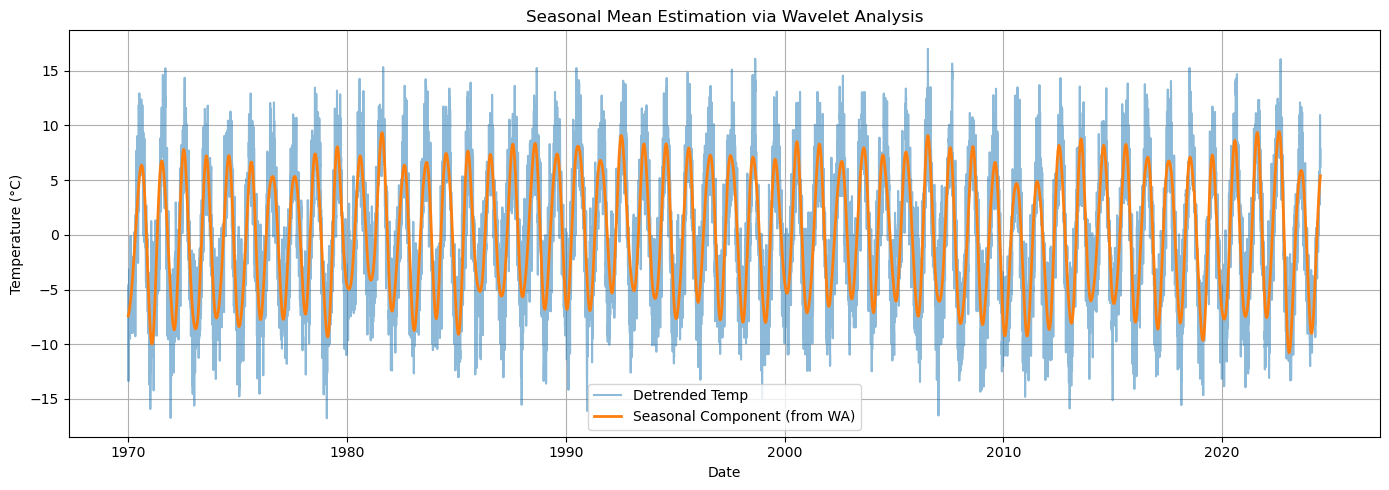

In [11]:
from WA_seasonal_mean import wavelet_reconstruct

keep = ['approx',  'detail_11', 'detail_10', 'detail_9', 'detail_8']   
# Reconstruct seasonal component
seasonal_component = wavelet_reconstruct(coeff_dict, keep, wavelet_name='db11')
# Add this code to visualize each wavelet detail level separately
plt.figure(figsize=(15, 10))

# Add to DataFrame
df['seasonal'] = seasonal_component[:len(df)]  # match original length in case of rounding

# Plot to visualize seasonal component
plt.figure(figsize=(14, 5))

plt.plot(df['date'], df['detrended_temp'], label='Detrended Temp', color='C0', alpha=0.5)
plt.plot(df['date'], df['seasonal'], label='Seasonal Component (from WA)', color='C1', linewidth=2)

plt.title('Seasonal Mean Estimation via Wavelet Analysis')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()

let's have a clearer idea by plotting just last 5 years

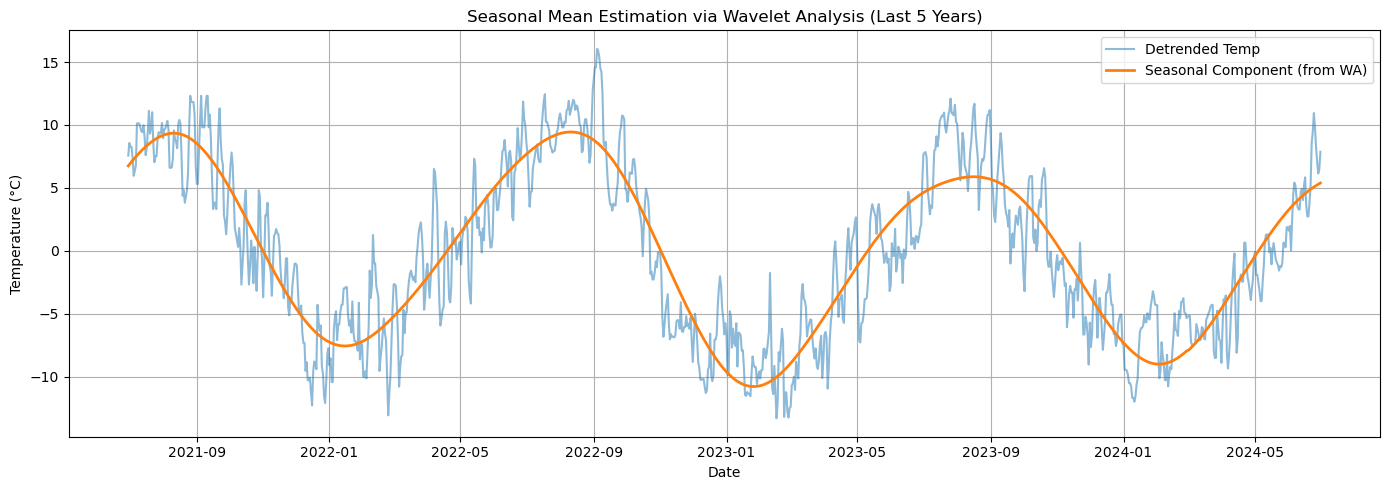

In [12]:
# Define the last 5-year window
end_date = df['date'].max()
start_date = end_date - pd.DateOffset(years=3)

# Filter the DataFrame
df_last5 = df[(df['date'] >= start_date) & (df['date'] <= end_date)]

# Plot to visualize seasonal component for the last 5 years
plt.figure(figsize=(14, 5))

plt.plot(df_last5['date'], df_last5['detrended_temp'], label='Detrended Temp', alpha=0.5)
plt.plot(df_last5['date'], df_last5['seasonal'], label='Seasonal Component (from WA)', color='C1', linewidth=2)

plt.title('Seasonal Mean Estimation via Wavelet Analysis (Last 5 Years)')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

let's compute the sinusoid

$$\mathcal{S}(t) = \sum_{i=1}^{n} a_i \cdot \sin\left( \frac{2\pi (t - \phi_i)}{p_i} \right)$$

Where:
*   $t$ is the day index
*   $a_i$: amplitude (to be fitted)
*   $\phi_i$: phase shift (to be fitted)
*   $p_i$: period in days (fixed from wavelet inspection)

/var/folders/8x/z8_ybmwx7tq_c10hj9qc7rx40000gn/T/ipykernel_1915/2548831415.py:37: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(seasonal_model, t, y, p0=initial_guess, maxfev=10000)


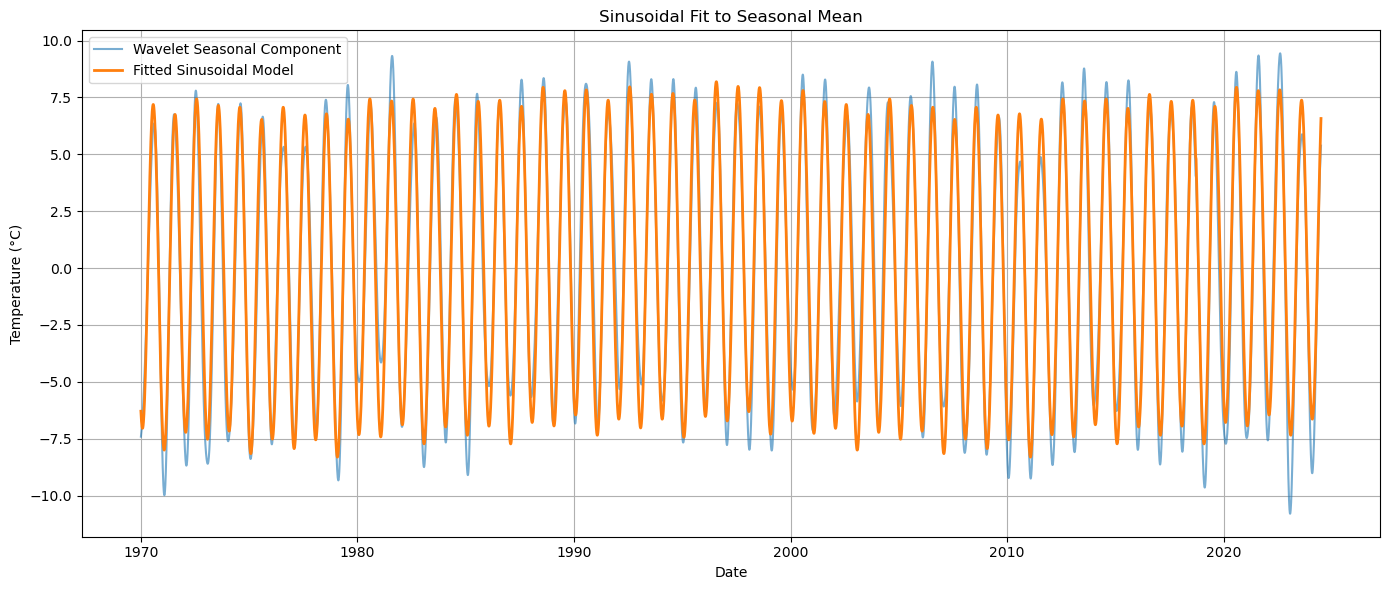

Cycle 1: Amplitude = -7.297, Phase Shift = 301.52, Period = 365 days
Cycle 2: Amplitude = -0.340, Phase Shift = 270.55, Period = 730 days
Cycle 3: Amplitude = -0.243, Phase Shift = 70.23, Period = 1460 days
Cycle 4: Amplitude = -0.170, Phase Shift = 5131.33, Period = 2920 days
Cycle 5: Amplitude = -0.118, Phase Shift = 430.99, Period = 5840 days
Cycle 6: Amplitude = -0.456, Phase Shift = -168.70, Period = 11680 days
Fitted constant C: 0.0832


In [13]:
from scipy.optimize import curve_fit

# Step 1: Define the periods
# You can fine-tune these later based on analysis or trial-error
periods = [365, 730, 1460, 2920, 5840, 11680]  
num_components = len(periods)
# Step 2: Define the sinusoidal model with these 3 fixed periods
def seasonal_model(t, C, *params):
    """
    Sinusoidal model with multiple components.
    params should be a flat list: [a1, phi1, a2, phi2, ..., aN, phiN]
    """
    seasonal_sum = 0
    for i in range(num_components):
        a_i = params[2*i]
        phi_i = params[2*i + 1]
        p_i = periods[i]
        seasonal_sum += a_i * np.sin(2 * np.pi * (t - phi_i) / p_i)
    return C + seasonal_sum

# Step 3: Prepare the data for fitting
t = df['t'].values
y = df['seasonal'].values
y_mean = np.mean(y)

# Initial guesses for [C0,a1, phi1, a2, phi2, a3, phi3]
initial_guess = [y_mean]
# Guesses for (amplitude, phase) for each period
initial_guess.extend([2, 300])  # Period 1460
initial_guess.extend([5, 200])  # Period 730
initial_guess.extend([10, 100]) # Period 365
initial_guess.extend([1, 50])   # Period 182.5
initial_guess.extend([0.5, 25]) # Period 91.25
initial_guess.extend([0.2, 10]) # Period 45.6
initial_guess.extend([0.1, 5])  # Period 22.8
# Step 4: Fit the sinusoidal model
popt, pcov = curve_fit(seasonal_model, t, y, p0=initial_guess, maxfev=10000)

# Generate fitted seasonal values
df['fitted_seasonal'] = seasonal_model(t, *popt)

# Step 5: Plot the result
plt.figure(figsize=(14, 6))
plt.plot(df['date'], df['seasonal'], label='Wavelet Seasonal Component', alpha=0.6)
plt.plot(df['date'], df['fitted_seasonal'], label='Fitted Sinusoidal Model', linewidth=2)
plt.title("Sinusoidal Fit to Seasonal Mean")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 6: Print the fitted parameters
for i in range(num_components):
    amp = popt[1 + 2*i]
    phase = popt[2 + 2*i]
    print(f"Cycle {i+1}: Amplitude = {amp:.3f}, Phase Shift = {phase:.2f}, Period = {periods[i]} days")

print(f"Fitted constant C: {popt[0]:.4f}")

In [14]:
# Convert popt (numpy array) to a list
seasonal_mean_params = popt.tolist()

with open("seasonal_mean_params.json", "w") as f:
    json.dump(seasonal_mean_params, f)

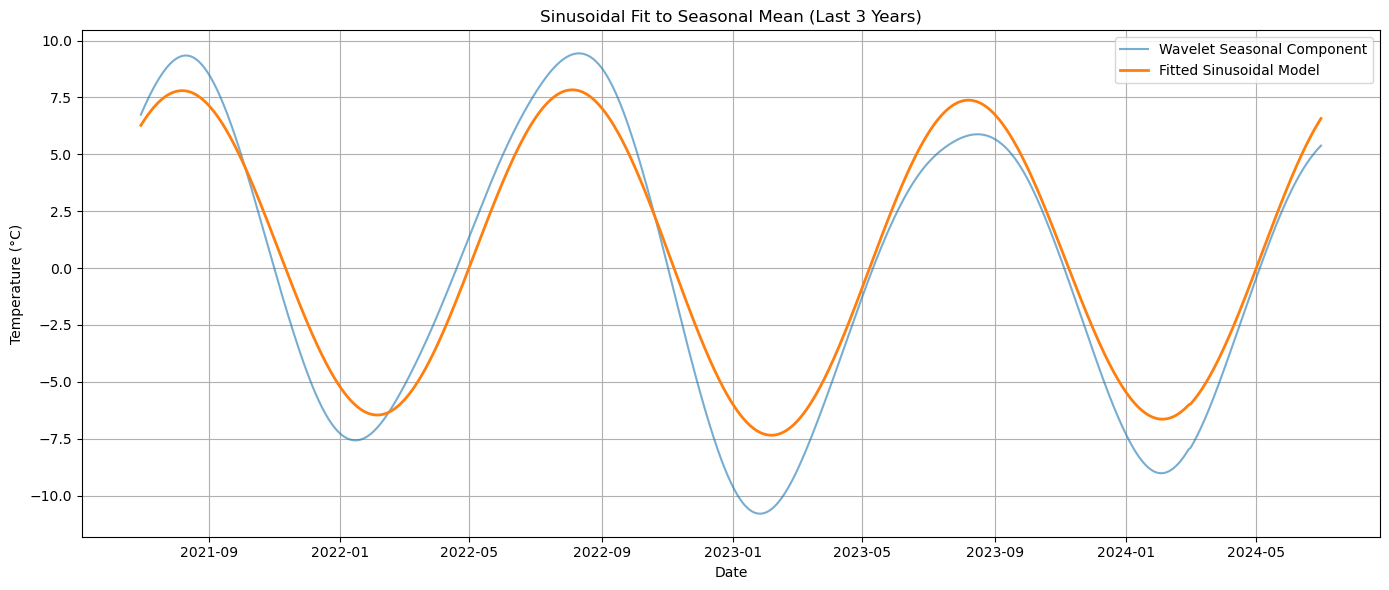

In [15]:
# Plot the last 3 years window
# Calculate the date 3 years before the last date
last_date = df['date'].max()
three_years_ago = last_date - pd.DateOffset(years=3)

# Filter the DataFrame
df_last_3years = df[df['date'] >= three_years_ago]

# Create the plot
plt.figure(figsize=(14, 6))
plt.plot(df_last_3years['date'], df_last_3years['seasonal'], label='Wavelet Seasonal Component', alpha=0.6)
plt.plot(df_last_3years['date'], df_last_3years['fitted_seasonal'], label='Fitted Sinusoidal Model', linewidth=2)
plt.title("Sinusoidal Fit to Seasonal Mean (Last 3 Years)")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Add residuals to the df for future steps

In [16]:
df['residual'] = df['detrended_temp'] - df['fitted_seasonal']

np.save("S_seasonal.npy", df["residual"].values)

And plot them

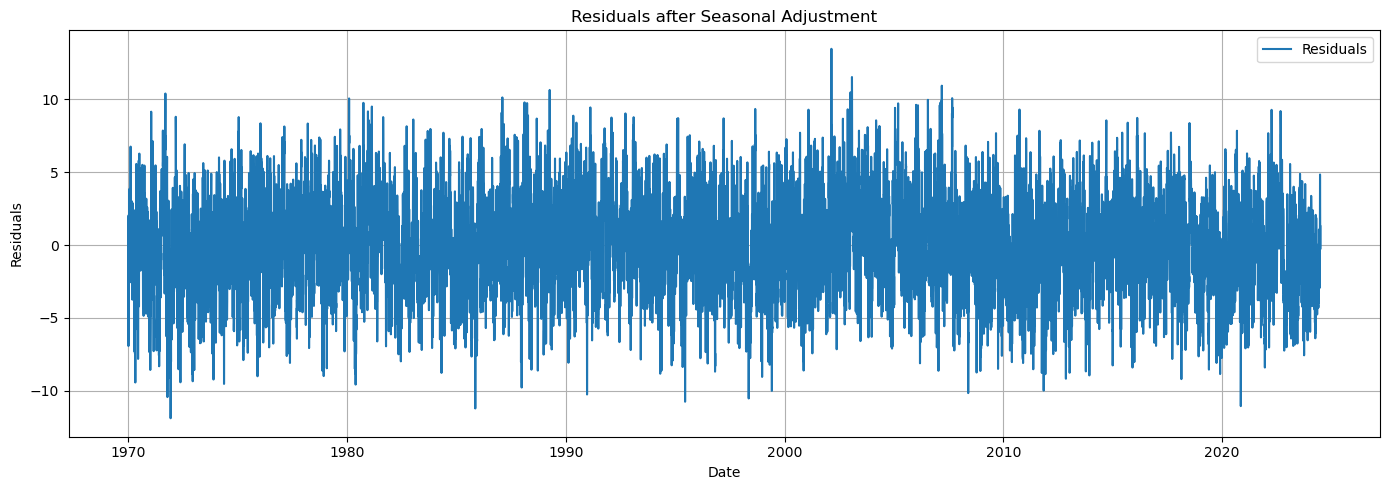

In [17]:
# Plot the residuals
plt.figure(figsize=(14, 5))
plt.plot(df['date'], df['residual'], label='Residuals', color='C0')
plt.title('Residuals after Seasonal Adjustment')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Estimating the Mean Reversion Speed

Call the Mean Reversion Speed Pipeline

In [18]:
from mean_rev_speed import fit_wavelet_model, WaveletNetwork

# resid is your pandas.Series of the deseasonalized residuals:
resid = pd.Series(df['residual'].values, index=pd.to_datetime(df['date']))

series = pd.Series(df['residual'].values, index=df['date'])

lags, best_h, k_ser, coefs, wn = fit_wavelet_model(
        series, max_lags=2, candidate_hids=[1,2,3,4,5], sbp_hid=3,
        lr=1e-2, epochs=1000, verbose=True,)

DEBUG: Forcing CPU for computation.
=== Wavelet Mean-Reversion Pipeline ===
--> SBP lag selection
[SBP] Starting with lags: [0, 1]
[SBP] Iter 1, lags: [0, 1]


/Users/filippogombac/Documents/GitHub/Minerva---Weather-Derivatives/Levy_process_model/WN_model/mean_rev_speed.py:171: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  torch.tensor(series.shift(i+1).fillna(method='bfill').values,


  [WN] Epoch 200/1000, loss=3.034355
  [WN] Epoch 400/1000, loss=3.022970
  [WN] Epoch 600/1000, loss=3.022444
  [WN] Epoch 800/1000, loss=3.022107
  [WN] Epoch 1000/1000, loss=3.021747
   [SBP] Lag 0 p=0.524
   [SBP] Lag 1 p=0.524
[SBP] Dropping lag 0 (p=0.524 > 0.1)
[SBP] Final lags: [1]
--> Hidden-dim selection via CV
[CV] Testing h=1
  [CV] fold 1, mse=5.915319
  [CV] fold 2, mse=6.052952
  [CV] fold 3, mse=6.067919
  [CV] fold 4, mse=6.050762
  [CV] fold 5, mse=6.000049
[CV] h=1, avg mse=6.017400
[CV] Testing h=2
  [CV] fold 1, mse=5.925269
  [CV] fold 2, mse=6.045253
  [CV] fold 3, mse=6.063201
  [CV] fold 4, mse=6.055157
  [CV] fold 5, mse=5.997423
[CV] h=2, avg mse=6.017260
[CV] Testing h=3
  [CV] fold 1, mse=5.924925
  [CV] fold 2, mse=6.042262
  [CV] fold 3, mse=6.064176
  [CV] fold 4, mse=6.050782
  [CV] fold 5, mse=6.002932
[CV] h=3, avg mse=6.017015
[CV] Testing h=4
  [CV] fold 1, mse=5.923609
  [CV] fold 2, mse=6.045851
  [CV] fold 3, mse=6.064773
  [CV] fold 4, mse=6.055

Save the results from training

In [19]:
# assemble everything into one dict
checkpoint = {
    'model_state_dict': wn.state_dict(),
    'lags':             lags,
    'hidden_dim':       best_h,
    'k_ser':            k_ser
}

# write to disk
torch.save(checkpoint, "wavelet_meanrev_checkpoint.pth")
print("✅ Saved to wavelet_meanrev_checkpoint.pth")

✅ Saved to wavelet_meanrev_checkpoint.pth


In [20]:
ckpt = torch.load("wavelet_meanrev_checkpoint.pth")

# 2) recreate the exact same architecture
input_dim   = len(ckpt['lags'])
hidden_dim  = ckpt['hidden_dim']
model       = WaveletNetwork(input_dim, hidden_dim)

# 3) load the saved parameters
model.load_state_dict(ckpt['model_state_dict'])

# 4) recover anything else you saved
lags = ckpt['lags']
k_ser = ckpt['k_ser']
print("✅ Loaded from wavelet_meanrev_checkpoint.pth")

✅ Loaded from wavelet_meanrev_checkpoint.pth


/var/folders/8x/z8_ybmwx7tq_c10hj9qc7rx40000gn/T/ipykernel_1915/2421741943.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("wavelet_meanrev_checkpoint.

In [21]:
# Add the k_series to the DataFrame
df['k_series'] = np.nan
df['k_series'] = k_ser.numpy()

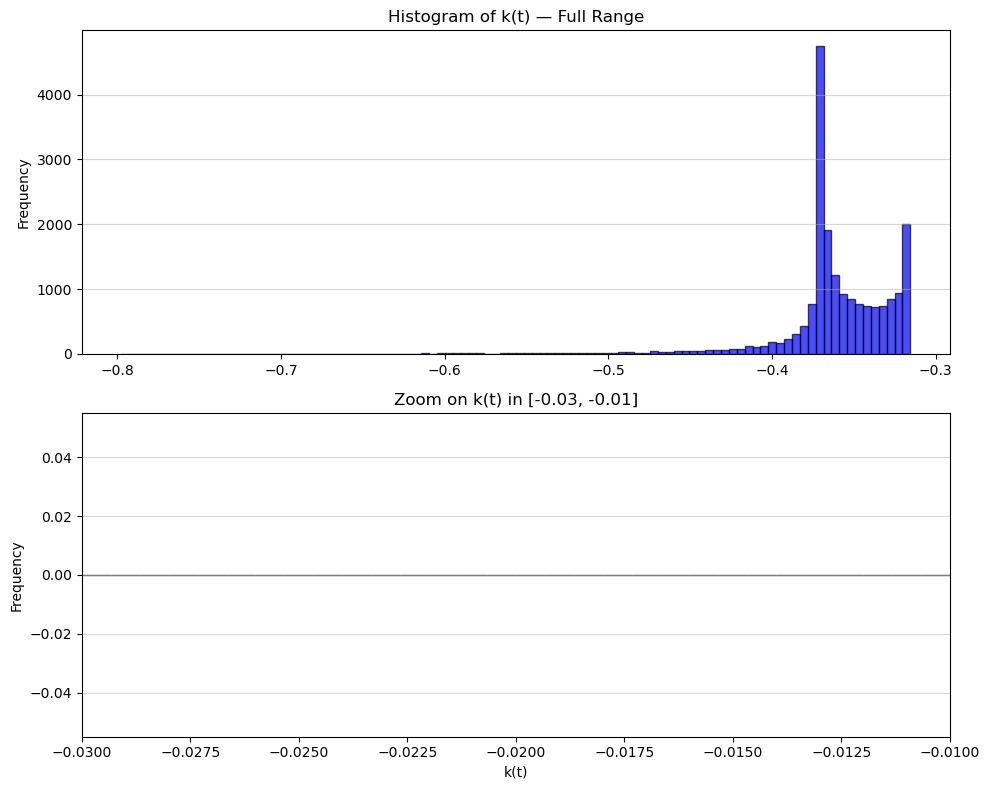

In [22]:
# your k(t) data
data = df['k_series'].values

# pick a “zoom window” around zero
zoom_min, zoom_max = -0.03, -0.01

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=False)

# ── 1) Full‐range histogram ────────────────────────────────────────
ax1.hist(data, bins=100, color='blue', alpha=0.7, edgecolor='black')
ax1.set_title('Histogram of k(t) — Full Range')
ax1.set_ylabel('Frequency')
ax1.grid(axis='y', alpha=0.5)

# ── 2) Zoomed histogram around small k(t) ───────────────────────
ax2.hist(data, bins=30, range=(zoom_min, zoom_max),
         color='blue', alpha=0.7, edgecolor='black')
ax2.set_title(f'Zoom on k(t) in [{zoom_min}, {zoom_max}]')
ax2.set_xlim(zoom_min, zoom_max)
ax2.set_xlabel('k(t)')
ax2.set_ylabel('Frequency')
ax2.grid(axis='y', alpha=0.5)

plt.tight_layout()
plt.show()

## VOLATILITY MODELLING

To model the variance, we work with squared residuals: (formula sbagliata)

$$
Y(t) = \left( T(t) - S(t) \right)^2 = X(t)^2 \approx \sigma^2(t)

In [23]:
df['residual_lag'] = df['residual'].shift(1)
df = df.reset_index(drop=True)
print(df)

            date   mean    max    min  average_temperature month_day      t  \
0     1970-01-01   5.50  18.28  -5.00                6.640     01-01      1   
1     1970-01-02  10.33  17.22   5.61               11.415     01-02      2   
2     1970-01-03   8.17  16.72  -2.78                6.970     01-03      3   
3     1970-01-04   4.39  13.89  -5.50                4.195     01-04      4   
4     1970-01-05   4.22  13.89  -4.39                4.750     01-05      5   
...          ...    ...    ...    ...                  ...       ...    ...   
19878 2024-06-26  25.50  34.89  18.00               26.445     06-26  19879   
19879 2024-06-27  24.61  33.72  16.89               25.305     06-27  19880   
19880 2024-06-28  24.22  34.00  14.72               24.360     06-28  19881   
19881 2024-06-29  24.17  35.11  14.28               24.695     06-29  19882   
19882 2024-06-30  26.72  37.89  14.28               26.085     06-30  19883   

           trend  detrended_temp  seasonal  fitted_

In [24]:
fitted_values = []


for t in range(1, len(df)):
    # difference from model prediction
    diff = df.loc[t, 'residual'] - (1 + df.loc[t, 'k_series']) * df.loc[t, 'residual_lag']
    
    fitted_values.append(diff)

fitted_values = np.array(fitted_values)

print(fitted_values)

[ 3.01549397 -4.31809883 -4.23745511 ... -0.7767304   0.15791345
  1.30559672]


In [25]:
print(fitted_values.mean()), print(fitted_values.std())

print(fitted_values.shape)

-0.05847873274018398
1.9014186316952226
(19882,)


In [26]:
df = df.iloc[1:].reset_index(drop=True)

In [27]:
df['fitted_values'] = fitted_values
df['squared_residual'] = fitted_values**2

print(len(df['squared_residual']))
df.head()

19882


,date,mean,max,min,average_temperature,month_day,t,trend,detrended_temp,seasonal,fitted_seasonal,residual,k_series,residual_lag,fitted_values,squared_residual
0,1970-01-02,10.33,17.22,5.61,11.415,01-02,2,17.568678,-6.153678,-7.386130,-6.344443,0.190765,-0.391022,-4.638477,3.015494,9.093204
1,1970-01-03,8.17,16.72,-2.78,6.970,01-03,3,17.568711,-10.598711,-7.363488,-6.396784,-4.201927,-0.391022,0.190765,-4.318099,18.645977
2,1970-01-04,4.39,13.89,-5.50,4.195,01-04,4,17.568744,-13.373744,-7.340130,-6.447175,-6.926569,-0.360029,-4.201927,-4.237455,17.956026
3,1970-01-05,4.22,13.89,-4.39,4.750,01-05,5,17.568777,-12.818777,-7.316051,-6.495602,-6.323175,-0.382573,-6.926569,-2.046527,4.188274
4,1970-01-06,9.33,16.72,2.78,9.750,01-06,6,17.568809,-7.818809,-7.291246,-6.542050,-1.276759,-0.487312,-6.323175,1.965055,3.861439


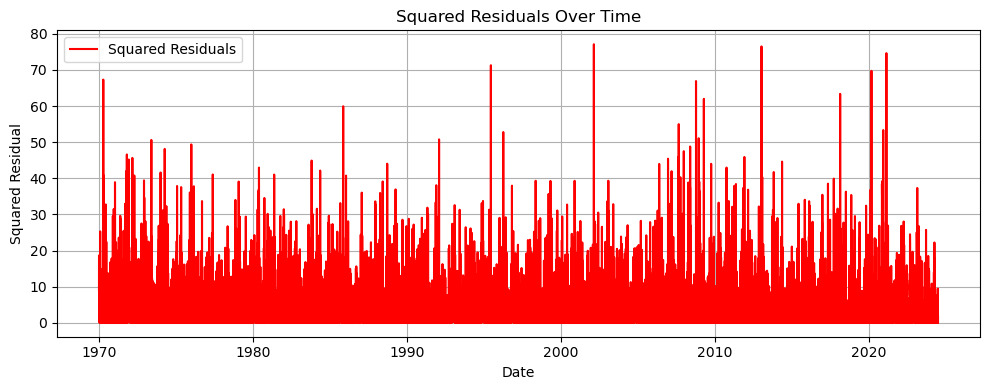

In [28]:
# Plot the squared residuals
plt.figure(figsize=(10, 4))
plt.plot(df['date'], df['squared_residual'], color='red', label='Squared Residuals')
plt.title("Squared Residuals Over Time")
plt.xlabel("Date")
plt.ylabel("Squared Residual")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


let's plot them:

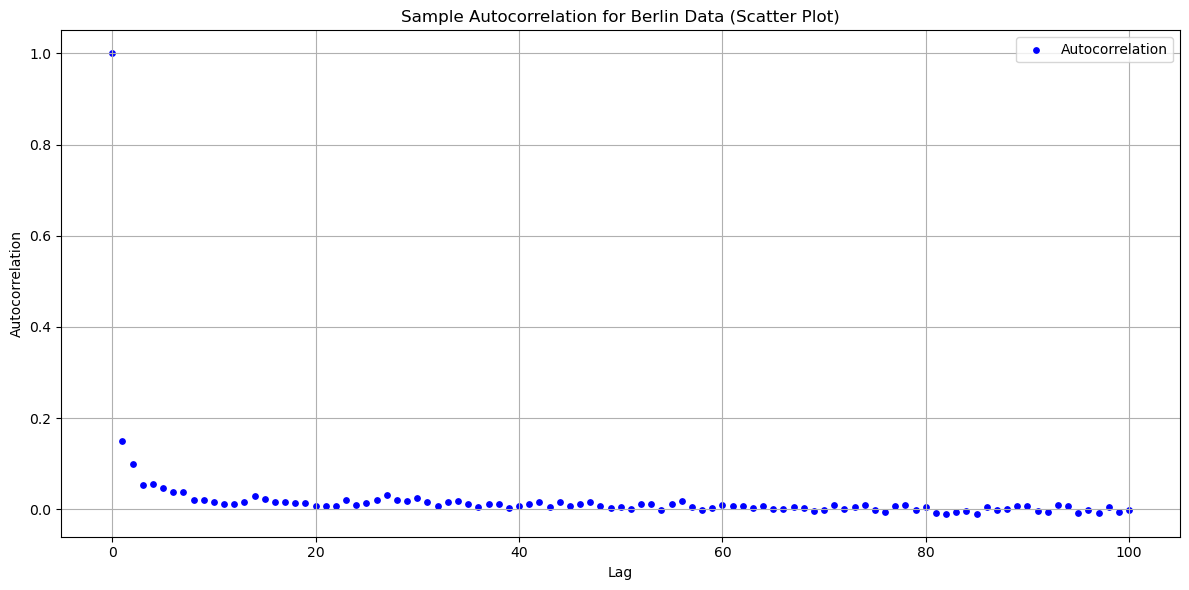

In [29]:
from statsmodels.tsa.stattools import acf

data = df['squared_residual'].values

# Compute the autocorrelation for lags 
nlags = 100
autocorr_vals = acf(data, nlags=nlags)

# Create an array of lags from 0 to 1000
lags = np.arange(nlags+1)

# Plot using a scatter plot
plt.figure(figsize=(12, 6))
plt.scatter(lags, autocorr_vals, color='blue', s=15, label='Autocorrelation')
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.title("Sample Autocorrelation for Berlin Data (Scatter Plot)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Construct the empirical variance

In [30]:
# Group by day_of_year and compute variance
empirical_variance = df.groupby('month_day')['fitted_values'].var(ddof=1)

# 'empirical_variance' is a Pandas Series whose index is [1..365]
# and each value is the sample variance of the residuals on that calendar day across all years.

print(empirical_variance)

month_day
01-01    5.011076
01-02    4.808147
01-03    4.975537
01-04    3.397408
01-05    4.509309
           ...   
12-27    2.834397
12-28    4.008979
12-29    5.439806
12-30    4.114753
12-31    2.686235
Name: fitted_values, Length: 365, dtype: float64


The volatility is also seasonal (e.g. winter more volatile than summer). So we do a wavelet decomposition of the squared residuals and reconstruct the seasonal part using appropriate detail levels. Essentialy we repeat what we did in the seasonal mean part

In [31]:
from WA_seasonal_mean import wavelet_decompose, wavelet_reconstruct

# ---------- Step 1: Wavelet Decomposition and Reconstruction of Squared Residuals ----------

# Decompose the squared residuals using wavelets (example with Daubechies 8)
vol_coeffs = wavelet_decompose(empirical_variance, wavelet_name='db8')

# Choose selected levels to capture the seasonal volatility structure.
keep_vol = ['approx', 'detail_8']

# Reconstruct the seasonal volatility component from these levels.
volatility_seasonal = wavelet_reconstruct(vol_coeffs, keep_vol, wavelet_name='db8')
volatility_seasonal = volatility_seasonal[:365]

# The x-axis values for the plot
days = np.arange(1, len(volatility_seasonal) + 1)


In [32]:
print(days.shape)
print(empirical_variance.shape)
print(volatility_seasonal.shape)

(365,)
(365,)
(365,)


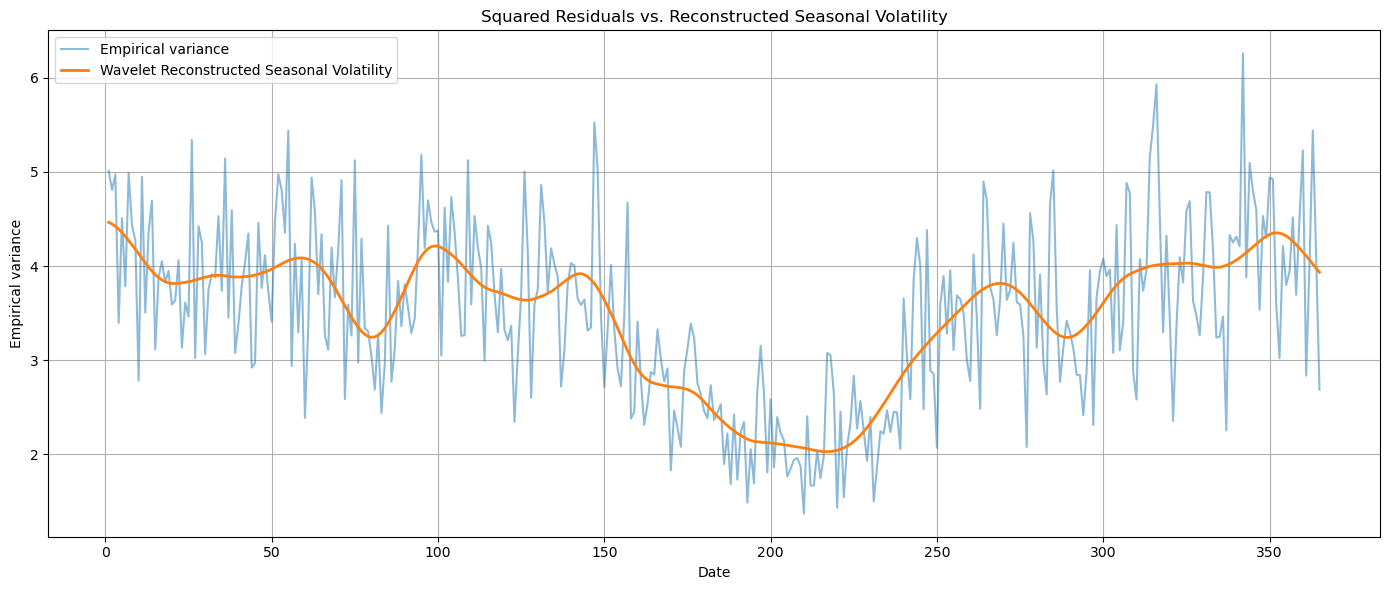

In [33]:
# ---------- Step 2: Plot the Squared Residuals and the Reconstructed Seasonal Volatility ----------

plt.figure(figsize=(14, 6))
plt.plot(days, empirical_variance, label='Empirical variance', alpha=0.5)
plt.plot(days, volatility_seasonal, label='Wavelet Reconstructed Seasonal Volatility', linewidth=2)
plt.title("Squared Residuals vs. Reconstructed Seasonal Volatility")
plt.xlabel("Date")
plt.ylabel("Empirical variance")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [34]:

# =============================================================================
# STEP 5: Define the Truncated Fourier Series Model for Variance
#
# We use the following model:
#
#   var(t) = c0 + sum_{k=1}^K [ a_k*cos(2*pi*k*t/365) + b_k*sin(2*pi*k*t/365) ]
#
# For demonstration, we set K = 4 harmonics.
# =============================================================================
def fourier_variance_model(t, c0, a1, b1, a2, b2, a3, b3, a4, b4):
    return (c0 +
            a1 * np.cos(2 * np.pi * 1 * t / 365) + b1 * np.sin(2 * np.pi * 1 * t / 365) +
            a2 * np.cos(2 * np.pi * 2 * t / 365) + b2 * np.sin(2 * np.pi * 2 * t / 365) +
            a3 * np.cos(2 * np.pi * 3 * t / 365) + b3 * np.sin(2 * np.pi * 3 * t / 365) +
            a4 * np.cos(2 * np.pi * 4 * t / 365) + b4 * np.sin(2 * np.pi * 4 * t / 365))

# =============================================================================
# STEP 6: Fit the Fourier Model Using curve_fit
#
# Although this model is linear in parameters, we will use curve_fit for consistency.
# =============================================================================
# Initial guesses (adjust these as needed based on the scale of your variance)
initial_guess = [5, 1, 1, 0.5, 0.5, 0.2, 0.2, 0.1, 0.1]

popt, pcov = curve_fit(fourier_variance_model, days, volatility_seasonal, p0=initial_guess)


In [35]:
from scipy.stats import t

n = len(volatility_seasonal)          # number of data points
p = len(popt)                         # number of parameters
dof = max(0, n - p)                   # degrees of freedom

# Standard errors from the diagonal of the covariance matrix
stderr = np.sqrt(np.diag(pcov))

# t-statistics for each parameter
t_stats = popt / stderr

# Two-tailed p-values for t-distribution
p_values = 2 * (1 - t.cdf(np.abs(t_stats), df=dof))

for i, (param, pval) in enumerate(zip(popt, p_values)):
    print(f"Param {i}: Estimate = {param:.4f}, p-value = {pval:.4g}")

Param 0: Estimate = 3.4827, p-value = 0
Param 1: Estimate = 0.7258, p-value = 0
Param 2: Estimate = 0.2657, p-value = 0
Param 3: Estimate = -0.2055, p-value = 0
Param 4: Estimate = -0.3334, p-value = 0
Param 5: Estimate = 0.1993, p-value = 0
Param 6: Estimate = 0.1709, p-value = 0
Param 7: Estimate = -0.0012, p-value = 0.9327
Param 8: Estimate = -0.1293, p-value = 0


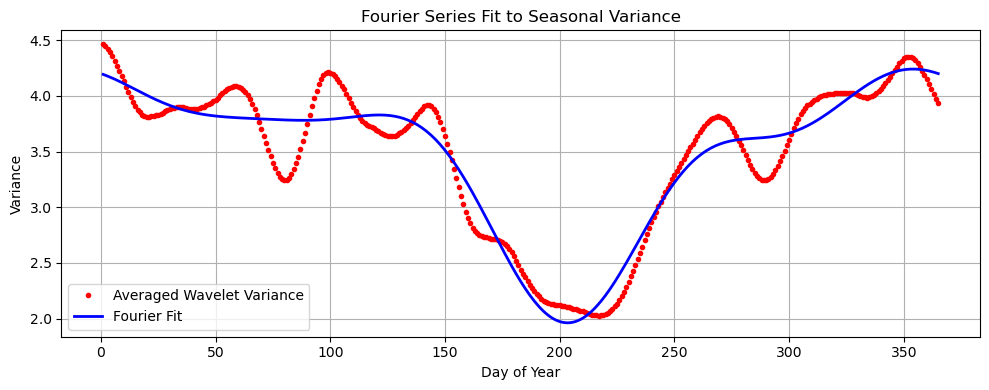

In [36]:
# Generate the fitted variance values from the Fourier model
fitted_var_fourier = fourier_variance_model(days, *popt)

# =============================================================================
# STEP 7: Plot the Fourier Fit vs Averaged Wavelet Variance
# =============================================================================
plt.figure(figsize=(10, 4))
plt.plot(days, volatility_seasonal, 'r.', label='Averaged Wavelet Variance')
plt.plot(days, fitted_var_fourier, 'b-', linewidth=2, label='Fourier Fit')
plt.title("Fourier Series Fit to Seasonal Variance")
plt.xlabel("Day of Year")
plt.ylabel("Variance")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


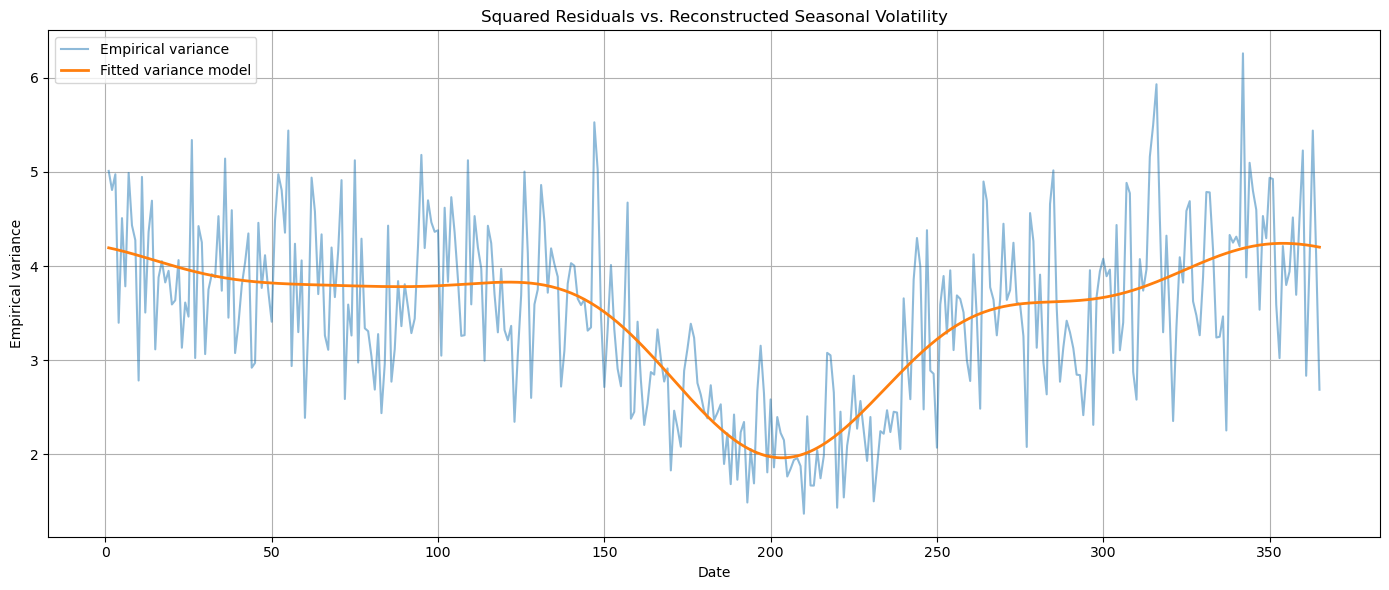

In [37]:
plt.figure(figsize=(14, 6))
plt.plot(days, empirical_variance, label='Empirical variance', alpha=0.5)
plt.plot(days, fitted_var_fourier, label='Fitted variance model', linewidth=2)
plt.title("Squared Residuals vs. Reconstructed Seasonal Volatility")
plt.xlabel("Date")
plt.ylabel("Empirical variance")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [38]:
print(fitted_var_fourier.shape)


(365,)


In [39]:
# Get day of year for each date in your dataframe
# If date is a column:
day_of_year = df['date'].dt.dayofyear

# If date is the index:
# day_of_year = df.index.dayofyear

# Create a mapping from day of year (1-366) to the fitted variance values
# We need a 366-day mapping to handle leap years (day 366 will just use day 365's value)
day_to_variance = {}
for i, day in enumerate(days):
    day_int = int(day)
    day_to_variance[day_int] = np.sqrt(fitted_var_fourier[i])

# If there's no day 366 in the model but we have leap years in the data
if 366 not in day_to_variance and max(days) < 366:
    day_to_variance[366] = day_to_variance[365]  # Use last day for leap years

# Map the sigma values to each day in the dataframe
df['sigma_t'] = day_of_year.map(lambda x: day_to_variance.get(x, np.nan))

# Check if all days got mapped properly
if df['sigma_t'].isna().any():
    print(f"Warning: {df['sigma_t'].isna().sum()} dates could not be mapped to the seasonal variance model")


np.save("sigma_timevarying.npy", df["sigma_t"].values)

In [40]:
# =============================================================================
# STEP 8: Print Fitted Parameters (Optional)
# =============================================================================
param_names = ['c0', 'a1', 'b1', 'a2', 'b2', 'a3', 'b3', 'a4', 'b4']
print("Fitted Fourier Model Parameters for Seasonal Variance:")
for name, value in zip(param_names, popt):
    print(f"{name} = {value:.4f}")

Fitted Fourier Model Parameters for Seasonal Variance:
c0 = 3.4827
a1 = 0.7258
b1 = 0.2657
a2 = -0.2055
b2 = -0.3334
a3 = 0.1993
b3 = 0.1709
a4 = -0.0012
b4 = -0.1293


In [41]:
# Convert popt (numpy array) to list
variance_params = popt.tolist()

# Save to JSON file
with open("variance_params.json", "w") as f:
    json.dump(variance_params, f)

# RESIDUAL ANALYSIS

We finally fit the model. First under the noramlity of residual assumption

## Normality and Brownian Motiron 

In [42]:
epsilons = []


for t in range(0, len(df)):
    
    e_t = df.loc[t, 'fitted_values'] / df.loc[t, 'sigma_t']
    epsilons.append(e_t)

epsilons = np.array(epsilons)
print(epsilons)


[ 1.47386535 -2.11258265 -2.07524639 ... -0.49742688  0.10187612
  0.84844614]


In [43]:
print(epsilons.mean()), 
print(epsilons.std())

-0.023237401547553552
1.0186729336892808


In [44]:
df['epsilons'] = epsilons

Normal distribution diagnostics

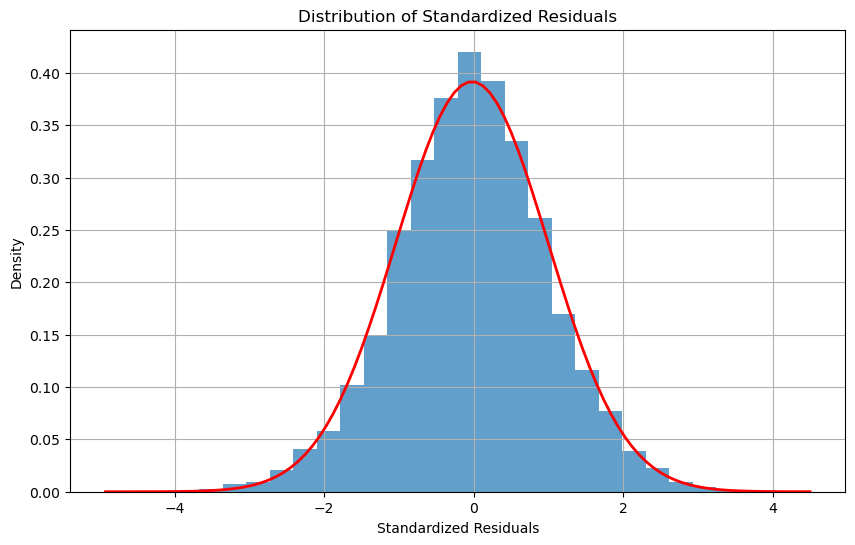

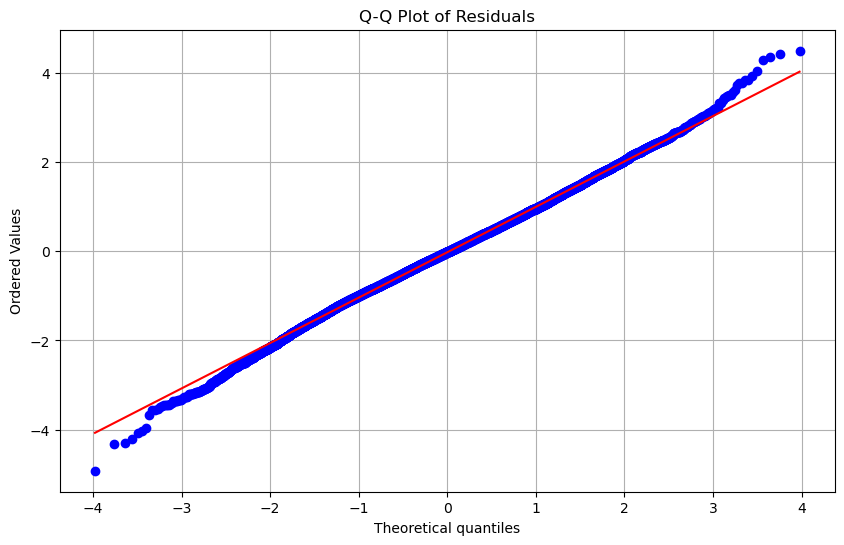


Residuals Summary Statistics:
Mean: -0.0232
Std Dev: 1.0187
Skewness: -0.0451
Kurtosis: 0.3805

Jarque-Bera test for normality:
Statistic: 126.6894
P-value: 0.0000
Reject normality hypothesis: True


In [45]:
import scipy.stats as stats


# Step 8: Check residuals for normality and independence
plt.figure(figsize=(10, 6))
plt.hist(epsilons, bins=30, alpha=0.7, density=True)
plt.title('Distribution of Standardized Residuals')
plt.xlabel('Standardized Residuals')
plt.ylabel('Density')

# Add normal distribution curve
x = np.linspace(min(epsilons), max(epsilons), 100)
plt.plot(x, stats.norm.pdf(x, np.mean(epsilons), np.std(epsilons)), 'r-', linewidth=2)
plt.grid(True)
plt.show()

# QQ plot for residuals
plt.figure(figsize=(10, 6))
stats.probplot(epsilons, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals')
plt.grid(True)
plt.show()

# Summary statistics
print("\nResiduals Summary Statistics:")
print(f"Mean: {np.mean(epsilons):.4f}")
print(f"Std Dev: {np.std(epsilons):.4f}")
print(f"Skewness: {stats.skew(epsilons):.4f}")
print(f"Kurtosis: {stats.kurtosis(epsilons):.4f}")

# Jarque-Bera test for normality
jb_stat, jb_pval = stats.jarque_bera(epsilons)
print(f"\nJarque-Bera test for normality:")
print(f"Statistic: {jb_stat:.4f}")
print(f"P-value: {jb_pval:.4f}")
print(f"Reject normality hypothesis: {jb_pval < 0.05}")

    


Ljung-Box Test for Autocorrelation of Residuals
       lb_stat      lb_pvalue
1   407.745592   1.134636e-90
5   633.854433  9.774973e-135
10  654.355800  3.914658e-134
15  660.652206  4.475035e-131
20  661.762546  2.687290e-127
30  680.922748  4.636869e-124

Interpretation:
Lag 1: Reject the null hypothesis - There is significant autocorrelation.
Lag 5: Reject the null hypothesis - There is significant autocorrelation.
Lag 10: Reject the null hypothesis - There is significant autocorrelation.
Lag 15: Reject the null hypothesis - There is significant autocorrelation.
Lag 20: Reject the null hypothesis - There is significant autocorrelation.
Lag 30: Reject the null hypothesis - There is significant autocorrelation.


<Figure size 1000x600 with 0 Axes>

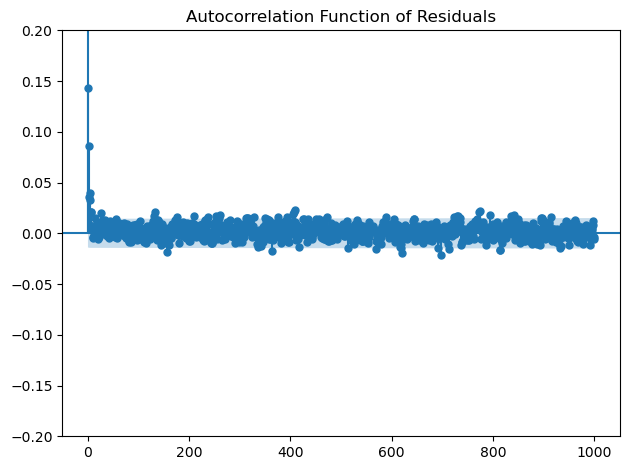

In [46]:
squared_epsilons = epsilons**2
from statsmodels.stats.diagnostic import acorr_ljungbox

# ---------- Ljung-Box Test for Autocorrelation ----------
print("\nLjung-Box Test for Autocorrelation of Residuals")
# Test for different lags
lags = [1, 5, 10, 15, 20, 30]

# Handle different versions of statsmodels
try:
    # Try with return_df=True (newer versions of statsmodels)
    lb_results = acorr_ljungbox(squared_epsilons, lags=lags, return_df=True)
    
    # Check if 'lb_pvalue' and 'lb_stat' exist, if not, rename 'model_qstat' and 'model_pvalue'
    if 'lb_pvalue' not in lb_results.columns and 'lb_stat' not in lb_results.columns:
        lb_results = lb_results.rename(columns={'model_qstat': 'lb_stat', 'model_pvalue': 'lb_pvalue'})
    
    # Already a DataFrame, just print it
    print(lb_results)
    print("\nInterpretation:")
    for lag in lags:
        # Find the row for this lag
        # Use .loc to find the row where 'lag' column equals the current lag
        # Check if 'lag' column exists, if not, create it
        if 'lag' not in lb_results.columns:
            lb_results['lag'] = lags[:len(lb_results)]  # Ensure 'lags' is not longer than lb_results
        row = lb_results.loc[lb_results['lag'] == lag]
       
        if not row.empty:
            p_value = row['lb_pvalue'].values[0]
            if p_value <= 0.05:
                print(f"Lag {lag}: Reject the null hypothesis - There is significant autocorrelation.")
            else:
                print(f"Lag {lag}: Failed to reject the null hypothesis - No significant autocorrelation.")
        else:
            print(f"Lag {lag}: Not found in Ljung-Box test results.")
        
except (TypeError, ValueError):
    # Fall back to older statsmodels version
    lb_stat, lb_pvalue = acorr_ljungbox(squared_epsilons, lags=lags)
    
    # Create a DataFrame for better visualization
    lb_df = pd.DataFrame({
        'Lag': lags,
        'Test Statistic': lb_stat,
        'p-value': lb_pvalue
    })
    
    print(lb_df)
    print("\nInterpretation:")
    for idx, lag in enumerate(lags):
        if lb_pvalue[idx] <= 0.05:
            print(f"Lag {lag}: Reject the null hypothesis - There is significant autocorrelation.")
        else:
            print(f"Lag {lag}: Failed to reject the null hypothesis - No significant autocorrelation.")

# Visual assessment of autocorrelation
from statsmodels.graphics.tsaplots import plot_acf
plt.figure(figsize=(10, 6))
plot_acf(squared_epsilons, lags=1000, alpha=0.05, title='Autocorrelation Function of Residuals')
plt.ylim(-0.2, 0.2)
plt.tight_layout()
plt.show()

## Levy process

Hyperbolic distribution diagnostics

Fitted parameters: p=7.268189043972141, a=0.5923903324528713, b=-0.014734075311196863, loc=0.07343452410390602, scale=0.15799488178111631


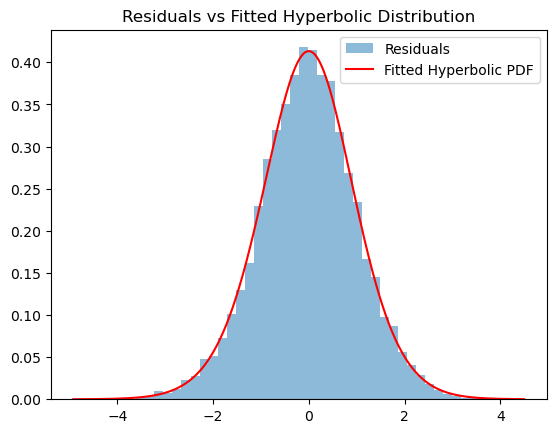

In [ ]:
from scipy.stats import genhyperbolic
from scipy.stats import kstest

# Fit the generalized hyperbolic distribution to the residuals.
params = genhyperbolic.fit(epsilons)

# Unpack the fitted parameters (shape parameters + loc and scale)
p, a, b, loc, scale = params
print(f"Fitted parameters: p={p}, a={a}, b={b}, loc={loc}, scale={scale}")

# Plot the histogram of residuals and the fitted hyperbolic PDF.
x = np.linspace(min(epsilons), max(epsilons), 1000)
pdf = genhyperbolic.pdf(x, *params)

plt.hist(epsilons, bins=50, density=True, alpha=0.5, label='Residuals')
plt.plot(x, pdf, label='Fitted Hyperbolic PDF', color='red')
plt.legend()
plt.title("Residuals vs Fitted Hyperbolic Distribution")
plt.show()

# For the QQ plot and K-S test, standardize your residuals.
# The fit returned loc and scale but statsmodels.qqplot will call
# genhyperbolic(*shape_params, loc=0, scale=1) internally.
# So, compute the standardized residuals:
eps_standardized = (epsilons - loc) / scale

# Extract only the shape parameters (excluding loc and scale)
shape_params = params[:-2]  # This gives (p, a, b)

# Create the QQ plot using the standardized residuals and the shape parameters.
sm.qqplot(eps_standardized, dist=genhyperbolic, distargs=shape_params, line='45')
plt.title("QQ Plot: Standardized Residuals vs Hyperbolic")
plt.show()

# Perform the Kolmogorov-Smirnov test on the standardized data.
ks_stat, p_value = kstest(eps_standardized, 'genhyperbolic', args=shape_params)
print(f"KS Statistic: {ks_stat}, p-value: {p_value}")


In [ ]:
hyperbolic_params = shape_params

# Save to JSON file
with open("hyperbolic_params.json", "w") as f:
    json.dump(hyperbolic_params, f)

Check for stationarity

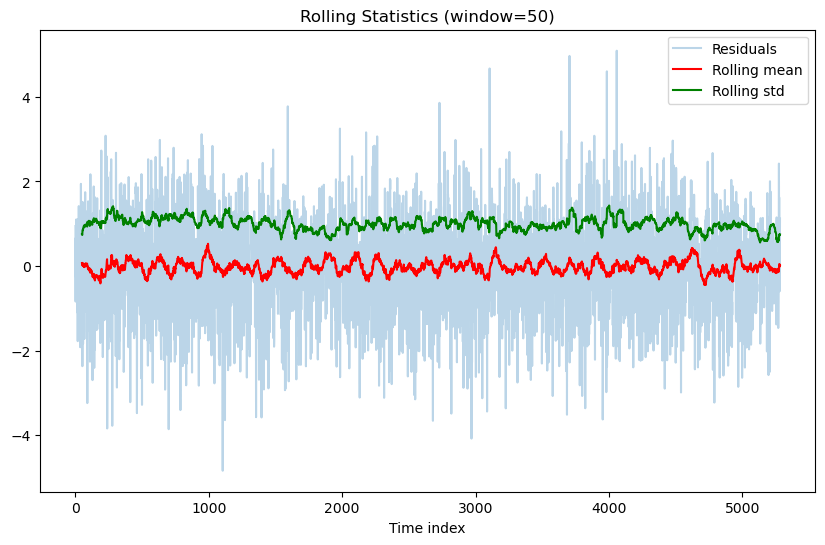

===== Augmented Dickey-Fuller Test =====
ADF Statistic: -24.000868646569874
p-value      : 0.0
Used lags    : 9
Number obs   : 5273
Critical values:
    1%, -3.431590752179765
    5%, -2.8620882845436224
    10%, -2.567061851453409
=> ADF: We reject the null hypothesis of a unit root -> likely STATIONARY.

===== KPSS Test =====
KPSS Statistic: 0.019251537058732487
p-value       : 0.1
Num lags      : 43
Critical values:
    10%, 0.347
    5%, 0.463
    2.5%, 0.574
    1%, 0.739
=> KPSS: We fail to reject the null hypothesis -> likely STATIONARY.


/var/folders/8x/z8_ybmwx7tq_c10hj9qc7rx40000gn/T/ipykernel_1851/2759103903.py:60: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, kpss_pvalue, kpss_lags, kpss_crit_vals = kpss(epsilons, regression='c', nlags='auto')


In [ ]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import kpss, adfuller

# Convert to a Pandas Series for rolling calculations
eps_series = pd.Series(epsilons)

# Choose a window size
window_size = 50

# Compute rolling statistics
rolling_mean = eps_series.rolling(window_size).mean()
rolling_std  = eps_series.rolling(window_size).std()

# --- Plotting ---

plt.figure(figsize=(10, 6))

# 1) Plot the original residuals (optional)
plt.plot(eps_series.index, eps_series.values, alpha=0.3, label='Residuals')

# 2) Plot rolling mean
plt.plot(rolling_mean.index, rolling_mean.values, color='red', label='Rolling mean')

# 3) Plot rolling std
plt.plot(rolling_std.index, rolling_std.values, color='green', label='Rolling std')

plt.title(f'Rolling Statistics (window={window_size})')
plt.xlabel('Time index')
plt.legend()
plt.show()


# 1) AUGMENTED DICKEY-FULLER TEST
print("===== Augmented Dickey-Fuller Test =====")
adf_result = adfuller(epsilons, autolag='AIC')
# adf_result is a tuple:
# (adf_stat, pvalue, usedlag, nobs, critical_values, icbest)
adf_stat = adf_result[0]
adf_pvalue = adf_result[1]
adf_usedlag = adf_result[2]
adf_nobs = adf_result[3]
adf_crit_vals = adf_result[4]

print(f"ADF Statistic: {adf_stat}")
print(f"p-value      : {adf_pvalue}")
print(f"Used lags    : {adf_usedlag}")
print(f"Number obs   : {adf_nobs}")
print("Critical values:")
for k, v in adf_crit_vals.items():
    print(f"    {k}, {v}")
    
if adf_pvalue < 0.05:
    print("=> ADF: We reject the null hypothesis of a unit root -> likely STATIONARY.")
else:
    print("=> ADF: We fail to reject the null hypothesis -> likely NON-STATIONARY.")

# 2) KPSS TEST
# KPSS has the opposite null: the data is STATIONARY.
print("\n===== KPSS Test =====")
kpss_stat, kpss_pvalue, kpss_lags, kpss_crit_vals = kpss(epsilons, regression='c', nlags='auto')
print(f"KPSS Statistic: {kpss_stat}")
print(f"p-value       : {kpss_pvalue}")
print(f"Num lags      : {kpss_lags}")
print("Critical values:")
for k, v in kpss_crit_vals.items():
    print(f"    {k}, {v}")

if kpss_pvalue < 0.05:
    print("=> KPSS: We reject the null hypothesis (stationarity) -> likely NON-STATIONARY.")
else:
    print("=> KPSS: We fail to reject the null hypothesis -> likely STATIONARY.")

Check for autocorrelation

In [ ]:
# Ljung-Box test for autocorrelation
from statsmodels.stats.diagnostic import acorr_ljungbox
lb_results = acorr_ljungbox(epsilons, lags=[7], return_df=False)

# Check the type of results and handle accordingly
if isinstance(lb_results, tuple) and len(lb_results) == 2:
    lb_stat, lb_pval = lb_results
    print(f"\nLjung-Box test for autocorrelation (lag=7):")
    print(f"Statistic: {float(lb_stat[0]):.4f}")
    print(f"P-value: {float(lb_pval[0]):.4f}")
    print(f"Evidence of autocorrelation: {float(lb_pval[0]) < 0.05}")
else:
    print("\nLjung-Box test for autocorrelation (lag=7):")
    print(f"Results: {lb_results}")


# Ljung-Box test for autocorrelation
from statsmodels.stats.diagnostic import acorr_ljungbox
lb_results = acorr_ljungbox(epsilons, lags=[14], return_df=False)

# Check the type of results and handle accordingly
if isinstance(lb_results, tuple) and len(lb_results) == 2:
    lb_stat, lb_pval = lb_results
    print(f"\nLjung-Box test for autocorrelation (lag=14):")
    print(f"Statistic: {float(lb_stat[0]):.4f}")
    print(f"P-value: {float(lb_pval[0]):.4f}")
    print(f"Evidence of autocorrelation: {float(lb_pval[0]) < 0.05}")
else:
    print("\nLjung-Box test for autocorrelation (lag=14):")
    print(f"Results: {lb_results}")


# Ljung-Box test for autocorrelation
from statsmodels.stats.diagnostic import acorr_ljungbox
lb_results = acorr_ljungbox(epsilons, lags=[21], return_df=False)

# Check the type of results and handle accordingly
if isinstance(lb_results, tuple) and len(lb_results) == 2:
    lb_stat, lb_pval = lb_results
    print(f"\nLjung-Box test for autocorrelation (lag=21):")
    print(f"Statistic: {float(lb_stat[0]):.4f}")
    print(f"P-value: {float(lb_pval[0]):.4f}")
    print(f"Evidence of autocorrelation: {float(lb_pval[0]) < 0.05}")
else:
    print("\nLjung-Box test for autocorrelation (lag=21):")
    print(f"Results: {lb_results}")


Ljung-Box test for autocorrelation (lag=7):
Results:      lb_stat     lb_pvalue
7  403.31857  4.632818e-83

Ljung-Box test for autocorrelation (lag=14):
Results:        lb_stat     lb_pvalue
14  433.673827  1.001199e-83

Ljung-Box test for autocorrelation (lag=21):
Results:       lb_stat     lb_pvalue
21  451.60955  1.815265e-82
